# Prediction of Radiology Downstream Cost
**Author:** `Bode O.`

#### Objectives
 - To establish the main features driving the downstream cost higher (inference)
 - To predict a selected and optmized model's predictive performance  (prediction)

#### The machine learning pipeline approach adopted for this task is break down as follows :

- <b><i>Getting the radiology data</i></b>: The features are available as batch data in a csv file, which was uploaded into this notebook before being subjected to wrangling and exploratory analysis.

- <b><i>Explore the data</i></b>: Here, any relationships, patterns or trends existing among the features are established for more insights on how to go about selecting a suitable machine learning algorithm.

- <b><i>Feature engineering</i></b>: During the step, insight from prior exploratory analysis would be harnessed to determine revelant features, combine and populate them in a suitable fashion to meet the challenge of predicting radiology downstream cost.

- <b><i>Model development </i></b>: Given the nature of the data, a regression type model was developed

- <b><i>Model evaluation</i></b>: The developed model system was diagnosed against underfitting, overfitting or both, and assessed to determine its ability to generalize to previously unseen data using suitable evaluation metrics (e.g., RMSE)

- <b><i>Summary</i></b>: The overall summary of my findings will be presents here

In [1]:
# Importing relevant libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
np.set_printoptions(suppress=True)

from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

### Loading the Data

In [2]:
# Loading radiology costing data into pandas dataframe

def load_radiology_data(filename):
    return pd.read_csv(os.path.join("datasets",filename))

filename = "radiology_costs.csv"
radiology_df = load_radiology_data(filename)
radiology_df.head()

,age,female,upstream_costs,er,hospital,population,downstream_cost
0,58,0,289.39,1,0,4555254,NaN
1,48,0,145.24,0,1,3527289,2335.50
2,48,1,252.29,0,1,1921463,2952.01
3,31,0,347.99,1,0,1045411,NaN
4,55,0,50.19,0,1,2007,2467.07


In [3]:
# checking for null values

radiology_df.info()
radiology_df["downstream_cost"].isnull().sum(axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              10000 non-null  int64  
 1   female           10000 non-null  int64  
 2   upstream_costs   10000 non-null  float64
 3   er               10000 non-null  int64  
 4   hospital         10000 non-null  int64  
 5   population       10000 non-null  int64  
 6   downstream_cost  7171 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 547.0 KB


2829

There are 10000 instances in total, with only the outcome variable (downstream_cost) having 2829 missing entries. Moreso, there are three categorical features (female, hospital and er).  The female feature is shorthanded for both genders (F & M), while hospital for patients imaged at hospital and those at community clinic. The er feature is for whether a patient took his/her image at emergency room visit

### Exploratory Data Analysis

In [4]:
# function to convert relevant columns to categorical attributes

def update_as_categorical(df,categorical_col_list):
    new_df = df.copy()
    for i in categorical_col_list:
        new_df[i]=df[i].astype('category')
    return new_df

In [5]:
categorical_col_list = ["female","hospital", "er"]
converted_radiology_df = update_as_categorical(radiology_df,categorical_col_list)
converted_radiology_df.head()

,age,female,upstream_costs,er,hospital,population,downstream_cost
0,58,0,289.39,1,0,4555254,NaN
1,48,0,145.24,0,1,3527289,2335.50
2,48,1,252.29,0,1,1921463,2952.01
3,31,0,347.99,1,0,1045411,NaN
4,55,0,50.19,0,1,2007,2467.07


In [6]:
# generating a descriptive summary statistics for the radiological data

radiology_df.describe().round(4)

,age,female,upstream_costs,er,hospital,population,downstream_cost
count,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000,1.000000e+04,7171.0000
mean,46.1752,0.5103,168.3622,0.2538,0.3945,1.757581e+06,2140.6996
std,6.8851,0.4999,90.1465,0.4352,0.4888,1.670278e+06,550.2637
min,25.0000,0.0000,23.8200,0.0000,0.0000,2.500000e+02,821.2300
25%,41.0000,0.0000,105.4600,0.0000,0.0000,2.132750e+03,1742.3800
50%,46.0000,1.0000,148.4450,0.0000,0.0000,1.437374e+06,2102.1100
75%,51.0000,1.0000,208.7225,1.0000,1.0000,3.258039e+06,2482.9450
max,79.0000,1.0000,938.8000,1.0000,1.0000,4.999149e+06,5746.0000


There exists extremely large degree of spread in the population attributes, ahout 25% of the zips have a population size lower than 2132 and 75% are lower than 3.25 millions. Only about 25% of the patients tooks their image from emergency room visits, and about 39% of all the patient were hospital visits. There appear to be fairly equal number of both gender (female = 51%, male = 49%).

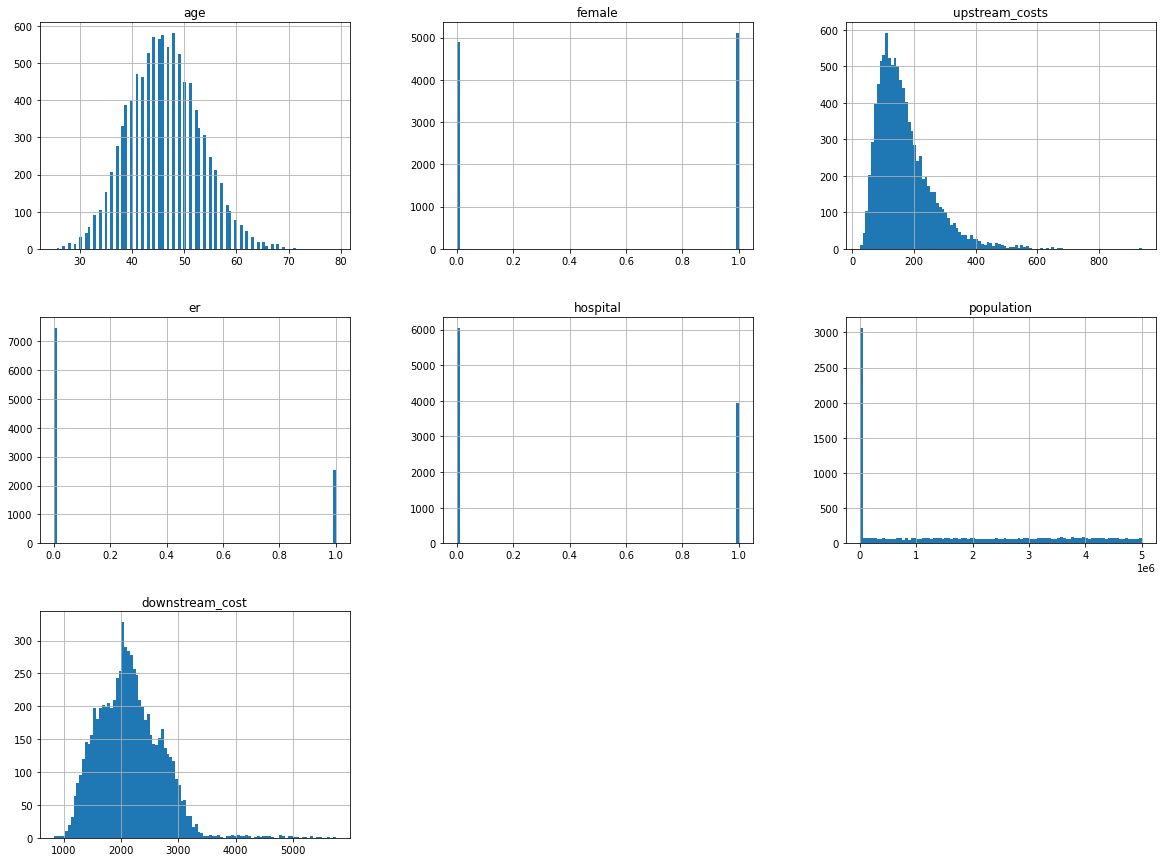

In [7]:
# generating a distribution plots for the data

radiology_df.hist(bins=100, figsize=(20,15))
plt.show()

The age attribute has a normal distribution, while those of upstream_costs and downstream_costs are right skewed. The distributions of female, er and hospital attributes are as expected (uniform). For the population attribute, about 30% of the patients have zips with populations less than 10000 (around 0.1e$^6$). More so, all the numerical attributes are on a difference scale. 

In [8]:
# count of the number of patients whose zips have population < 10,0000

radiology_df[(radiology_df["population"]< 10000)].count()["population"]

3014

#### - Data Cleaning or Imputation

My initial approach involves the removal of radiological data whose outcome variables are missing. This approach was taken because missing observations were found in the downstream_cost (outcome attribute) only. Depending on time, I plan on trying different imputation techniques for the outcome variable.

In [9]:
# removing data with missing downstream_cost attributes

clean_radiology_df = radiology_df[radiology_df["downstream_cost"].notnull()]
clean_radiology_df.head()

,age,female,upstream_costs,er,hospital,population,downstream_cost
1,48,0,145.24,0,1,3527289,2335.50
2,48,1,252.29,0,1,1921463,2952.01
4,55,0,50.19,0,1,2007,2467.07
5,38,0,221.21,0,1,2079041,2115.18
6,38,0,173.92,0,0,436433,1337.43


#### - Splitting the Data

A portion of the data is held out for subsequent generalization testing. For this work, 15% of the clean data will be held out.

In [10]:
train_set, test_set = train_test_split(clean_radiology_df, test_size=0.15,random_state=42)

#### - Further Exploratory Analysis

In [11]:
rad_df = train_set.copy()
num_attr =['age','upstream_costs','population','downstream_cost']

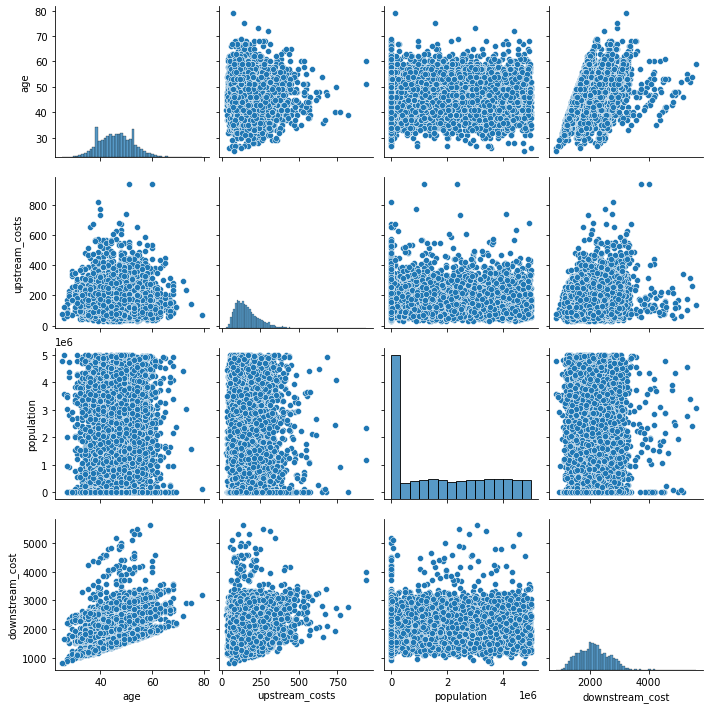

In [12]:
# examining the relationship between two features

sns.pairplot(rad_df[num_attr])
plt.show()

In [13]:
# conducting pearson correlation on the dataset

corr_matrix = rad_df[num_attr].corr()

In [14]:
# writing a function for visualizing correlation data

def corr_heatmap(corr_df, figsize=(10,10), annot=False, cbar=True):
    """Return a heatmap of a dataframe containing 
    Pearson correlation values
    
    Arg
    ---
        corr_df: a Pandas.DataFrame correlation table
    """
    # define figure
    fig, ax = plt.subplots(figsize=figsize)
    
    corr_df = np.round(corr_df,decimals=3)
    
    sns.heatmap(corr_df, annot=annot, fmt='.2g',
                annot_kws={'size': 14}, square=True, 
                cbar=cbar, cmap="YlGnBu", cbar_kws={"shrink": .75})
    plt.title('Pearson Correlations for the Radiology Costing Data', fontsize=20)
    plt.xlabel('Features', fontsize=18)
    plt.xticks(fontsize=12, rotation='vertical')
    plt.ylabel('Features', fontsize=18)
    plt.yticks(fontsize=12, rotation='horizontal')
    plt.tight_layout()
    
    plt.show()

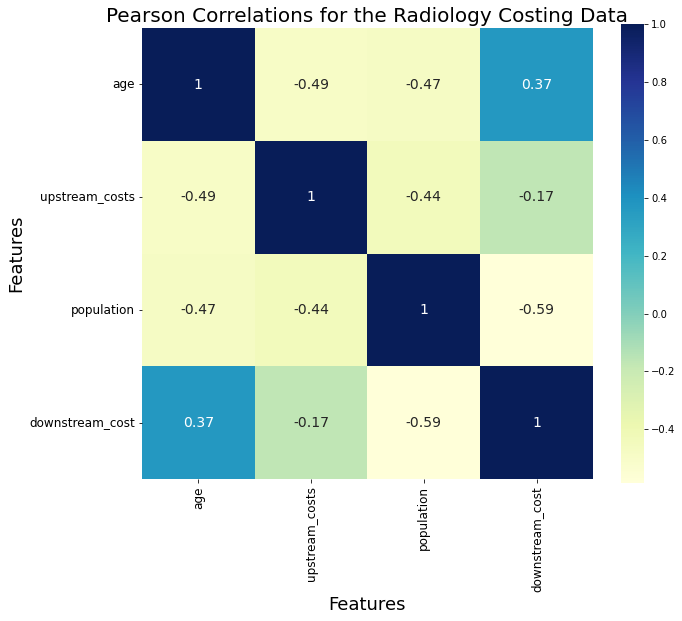

In [15]:
# visualizing the Pearson correlation with seaborn heatmap

corr_heatmap(corr_matrix.corr(),annot=True)

As seen from the pairplot and correlation matrix, age is the most positively correlated to downstream_cost compared to other numerical attributes, while pouplation is the most negatively correlated. upstream_costs and population have negative correlations to each of the other attributes. Age appears to have a linear relationship with downstream_cost.

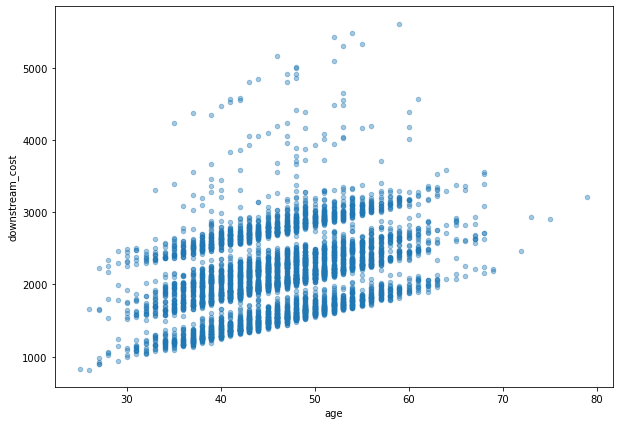

In [16]:
# Visualizing the relationship between age and downstream_cost (follow up to finding from pairplot)

rad_df.plot(kind ="scatter", x="age", y="downstream_cost", alpha=0.4, figsize=(10,7))
plt.show()

### Model Development

In [17]:
# grouping the training set into X (independent variables) and y (outcome)

coded_rad_X = train_set.drop("downstream_cost", axis=1).copy()
rad_y = train_set["downstream_cost"].copy()

In [18]:
X_cat_attr =["female","hospital","er"]

def get_category_col_value(i):
    mapping = {"female_map":{1:"female",0:"male"},
               "hospital_map":{1:"hospital",0:"community_clinic"},
               "er_map":{1:"er",0:"not_er"}}
    i_map = i + "_map"
    return mapping[i_map]


def update_categorical_map(df,cat_attr):
    new_df =df.copy()
    for i in cat_attr:
        i_map = get_category_col_value(i)
        new_df[i]=new_df[i].map(i_map)
    return new_df

In [19]:
rad_X = update_categorical_map(coded_rad_X,X_cat_attr)
rad_X.head()

,age,female,upstream_costs,er,hospital,population
3512,51,male,122.93,not_er,hospital,2984278
2389,55,female,240.58,not_er,hospital,2617763
2031,37,male,209.79,not_er,community_clinic,395666
4893,45,female,194.55,not_er,hospital,4173950
1536,52,male,443.90,not_er,hospital,3173759


In [20]:
# creating pipleine for transforming categorical attributes and scaling numerical attribute

X_num_attr = [col for col in num_attr if col != "downstream_cost"]

full_pipe = ColumnTransformer([
    ("X_num", StandardScaler(), X_num_attr),
    ("X_cat", OneHotEncoder(), X_cat_attr)])

rad_X_prepared = full_pipe.fit_transform(rad_X)
rad_X_prepared_cols = X_num_attr +list(full_pipe.named_transformers_['X_cat'].get_feature_names())

In [21]:
def get_scores(prefix, scores):
    print(prefix+"scores:", [round(i, 5) for i in scores])
    print(prefix+"scores mean:", round(scores.mean(),5))
    print(prefix+"scores standard deviation:", round(scores.std(),5))
    

def get_diff_models_cv_scores(model_list, X, y):
    # model_list is a list of tuples (model class, prefix)
    for i in model_list:
        scores = cross_val_score(i[0], rad_X_prepared, rad_y, 
                             scoring="r2", cv=10)
        prefix = i[1]
        if i != model_list[-1]:
            get_scores(prefix, scores)
            print()
        else:
            get_scores(prefix, scores)

In [22]:
# trying different models with cross-validation 

model_list = [(LinearRegression(), "lin_"),
              (DecisionTreeRegressor(), "tree_"),
              (RandomForestRegressor(), "forest_"),]

get_diff_models_cv_scores(model_list, rad_X_prepared, rad_y)

lin_scores: [0.99271, 0.99688, 0.99564, 0.99311, 0.99184, 0.99352, 0.994, 0.99125, 0.99744, 0.99571]
lin_scores mean: 0.99421
lin_scores standard deviation: 0.00201

tree_scores: [0.99491, 0.99566, 0.99438, 0.99494, 0.99568, 0.9959, 0.99588, 0.9952, 0.99416, 0.996]
tree_scores mean: 0.99527
tree_scores standard deviation: 0.00062

forest_scores: [0.99513, 0.99649, 0.99632, 0.99688, 0.99803, 0.99797, 0.99811, 0.99711, 0.99604, 0.99808]
forest_scores mean: 0.99702
forest_scores standard deviation: 0.00098


### Hyperparameter tuning

In [23]:
# different models with hyperparameter tuning

# Since the R squared values for the three models are very similar. The initial model, only the hyperparameters for the
# linear regression is further fine-tuned

alpha = [0.0001,0.001,0.01,0.05,0.1,1,10,100,1000]
lasso = Lasso()
ridge = Ridge()


param_grid = dict(alpha=alpha)

grid_ridge = GridSearchCV(estimator=ridge,
                    param_grid=param_grid,
                    cv = 10, return_train_score=True,
                    scoring='r2',
                    verbose=1,
                    n_jobs=-1)

grid_ridge_result = grid_ridge.fit(rad_X_prepared, rad_y)

print('Best Ridge Score:', "{:.8f}".format(grid_ridge_result.best_score_))
print('Best Rdige Params:', grid_ridge_result.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best Ridge Score: 0.99421072
Best Rdige Params: {'alpha': 0.1}


In [24]:
grid_ridge_result.cv_results_['mean_train_score']

array([0.99422471, 0.99422471, 0.99422471, 0.9942247 , 0.99422467,
       0.99422009, 0.99380183, 0.97362607, 0.82351234])

In [25]:
grid_lasso = GridSearchCV(estimator=lasso,
                    param_grid=param_grid,
                    cv = 10, return_train_score=True,
                    scoring='r2',
                    verbose=1,
                    n_jobs=-1)

grid_lasso_result = grid_lasso.fit(rad_X_prepared, rad_y)

print('Best Lasso Score:', "{:.8f}".format(grid_lasso_result.best_score_))
print('Best Lasso Params:', grid_lasso_result.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best Lasso Score: 0.99421083
Best Lasso Params: {'alpha': 0.05}


In [26]:
gridres = grid_ridge_result.cv_results_
for mean_score, params in zip(
    gridres["mean_test_score"],gridres["params"]):
    print(mean_score, params)

0.9942104336538229 {'alpha': 0.0001}
0.9942104366975153 {'alpha': 0.001}
0.9942104667122444 {'alpha': 0.01}
0.9942105908284724 {'alpha': 0.05}
0.9942107246835212 {'alpha': 0.1}
0.9942091299921556 {'alpha': 1}
0.9938157473033643 {'alpha': 10}
0.9737024341482622 {'alpha': 100}
0.823683309318071 {'alpha': 1000}


In [27]:
sorted(zip(grid_ridge_result.best_estimator_.coef_,rad_X_prepared_cols), reverse=True)

[(851.5619633994851, 'x2_er'),
 (378.9231444454968, 'x1_hospital'),
 (252.05723962996635, 'x0_female'),
 (209.39075769773547, 'age'),
 (89.09736325470402, 'upstream_costs'),
 (-5.223001182158813, 'population'),
 (-252.057239629972, 'x0_male'),
 (-378.9231444436381, 'x1_community_clinic'),
 (-851.561963399188, 'x2_not_er')]

### Model Evaluation (on Test Set)

In [28]:
final_model = grid_ridge_result.best_estimator_

coded_rad_test_X = test_set.drop("downstream_cost", axis=1)
rad_test_y = test_set["downstream_cost"].copy()

rad_test_X = update_categorical_map(coded_rad_test_X,X_cat_attr)
rad_test_X_prepared = full_pipe.transform(rad_test_X)

predictions = final_model.predict(rad_test_X_prepared)
test_rmse = np.sqrt(mean_squared_error(rad_test_y, predictions))
round(test_rmse,2)

50.8

In [29]:
def get_95_confidence_interval(y_predict, y_test):
    squared_errors = (y_predict - y_test)**2
    confidence = 0.95
    return np.sqrt(stats.t.interval(confidence,len(y_predict)-1,
                             loc = squared_errors.mean(),
                             scale=stats.sem(squared_errors)))

def get_metric_values(y_test, y_predict):
    res = []
    res.append(mean_squared_error(y_test, y_predict))
    res.append(np.sqrt(mean_squared_error(y_test, y_predict)))
    res.append(mean_absolute_error(y_test, y_predict))
    res.append(explained_variance_score(y_test, y_predict))
    res.append(r2_score(y_test, y_predict))
    res_columns = ["MSE", "RMSE", "MAE", "explained_variance","r2_score"]
    return res, res_columns


In [30]:
get_95_confidence_interval(rad_test_y, predictions)

array([29.47193845, 65.52614524])

In [31]:
metrics, metric_cols = get_metric_values(rad_test_y, predictions)
metric_df = pd.DataFrame(metrics, index = metric_cols, columns = ["metric_values"])

metric_df

,metric_values
MSE,2581.135433
RMSE,50.804876
MAE,14.913449
explained_variance,0.991322
r2_score,0.991321


### Summary

A linear regression model was used to fit the radiology training dataset and when combined with ridge or lasso regularizations, only an infinitesimal small amount of improvement was observed. Based on the model r$^2$ value, over 99% of the variance in the downstream costs was explained by the attributes for both training and validation sets. Analysis of the model's predictive performance showed that the developed model generalized well, with a r$^2$ value > 0.99 and RMSE of approx. 50 which is over one order of magnitude less than the standard deviation of downstream costs in the dataset (~550). The 95% confidence interval for RMSE of the generalization is (29.5, 65.5). During the model building phase, it was assumed that the relationships between attributes and downstream costs are linear, each instance is independent, the variance of residuals is the same for all attributes and that downward cost is normally distributed for any fixed attributes. More so, the concept of generalization for linear regression is built on the fact that the radiology data attributes whose downstream costs are being predicted are from the same distribution as the training set. As such, the model is not expected to be suited for radiologic attributes taken from a different distribution.